In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from ENDF6 import *
import sqlite3

In [2]:
# change cwd to the directory of the script
import os
abspath = "/home/john/Documents/MCXrayTransport/data/sql_database_generator.ipynb"
dname = os.path.dirname(abspath)
os.chdir(dname)
print(os.getcwd())


/home/john/Documents/MCXrayTransport/data


In [4]:
import pint

ModuleNotFoundError: No module named 'pint'

In [3]:
u = pint.UnitRegistry()

In [4]:
p = 1 * u.m_e * u.c

In [5]:
print((p / (4.137e-15 * u.eV * u.s)).to(1/u.angstrom))


41.20157176762781 / angstrom


In [13]:
# convert momentum in terms of eV * c to 1/angstrom without using pint
def p_

In [16]:
p_to_1_over_angstrom(2.5 /0.511e6)

0.11825883263395061

# Graphs of each table for Hydrogen in order to ensure that data is read correctly

In [12]:
data_dict = {"total cross sections": (23, 501), "coherent scattering cross sections": (23, 502), "incoherent scattering cross sections": (23, 504), "pair production cross sections, electron field": (23, 515), "pair production cross sections, total": (23, 516), "pair production cross sections, nuclear field": (23, 517), "total photoionization cross sections": (23, 522), "coherent scattering form factors": (27, 502), "incoherent scattering functions": (27, 504), "imaginary anomalous scattering factor": (27, 505),
             "real anomalous scattering factor": (27, 506)}

In [13]:
def plot_data(atomic_number, data_type, xscale = "log", yscale = "log", xlim = None, ylim = None):
    data = data_dict[data_type]
    f = open(f"data_sources/EPDL/{atomic_number:03d}.txt")
    lines = f.readlines()
    sec = find_section(lines, data[0], data[1])
    x, y = read_table(sec)
    plt.plot(x, y, label = data_type)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xscale(xscale)
    plt.yscale(yscale)


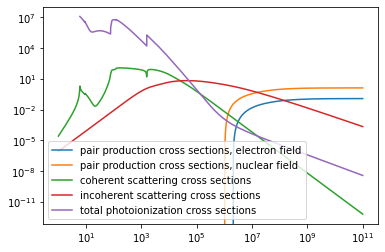

In [14]:
plot_data(13, "pair production cross sections, electron field")
plot_data(13, "pair production cross sections, nuclear field")
plot_data(13, "coherent scattering cross sections")
plot_data(13, "incoherent scattering cross sections")
plot_data(13, "total photoionization cross sections")
plt.legend()

In [3]:
from sqlalchemy import create_engine

In [4]:
ID = np.arange(1, 101)
Symbol = np.array(["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na",
                   "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti",
                   "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge",
                   "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo",
                   "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te",
                   "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm",
                   "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf",
                   "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb",
                   "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U",
                   "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm"])
AtomicNumber = np.arange(1, 101)


In [5]:
import periodictable as pt
import mendeleev as md

In [15]:
# get all elements from mendeleev
el = md.element(101)
el.mass_number

244

In [17]:
Mass = np.array([pt.elements[i].mass for i in range(1, 101)]) # g
Density = np.array([pt.elements[i].density for i in range(1, 101)]) # g/cm^3
NumberDensity = np.array([pt.elements[i].number_density for i in range(1, 101)]) # atoms/cm^3
MassNumber = np.array([md.element(i).mass_number for i in range(1, 101)]) # number of nucleons

100

In [18]:
elements_df = pd.DataFrame({"ID": ID, "Symbol": Symbol, "AtomicNumber": AtomicNumber, "Mass": Mass, "Density": Density, "NumberDensity": NumberDensity,
                            "MassNumber": MassNumber})

In [19]:
engine = create_engine("sqlite:///data_sources/EPDL/EPDL.db", echo = False)

In [20]:
elements_df.to_sql("Elements", con = engine, if_exists = "replace", index = False)

100

In [ ]:
def repeat_or_explode(val):
    if isinstance(val, list):
        return len(val)
    else:
        return 1

def add_sql_table(table_name, data_type, y_name):
    tot = 0
    data = data_dict[data_type]
    df_list = []  # Create an empty list to store DataFrames
    for Z in AtomicNumber:
        with open(f"data_sources/EPDL/{Z:03d}.txt") as f:
            lines = f.readlines()
            sec = find_section(lines, data[0], data[1])
            x, y = read_table(sec)
            tot += len(x)
            df = pd.DataFrame({"ElementID": Z, "Energy": x, y_name: y})
            df = df.apply(lambda x: x.explode() if x.name in ['Energy', y_name] else x.repeat(df['Energy'].apply(repeat_or_explode)))
            df_list.append(df)  # Append the DataFrame to the list

    # Concatenate all the DataFrames in the list into one DataFrame
    final_df = pd.concat(df_list, ignore_index=True)

    # Write the final DataFrame to the SQL table
    final_df.to_sql(table_name, con = engine, if_exists = "replace", index = True)
    print(f"Added {tot} rows to {table_name} table")

In [ ]:
add_sql_table("TotalCrossSections", "total cross sections", "CrossSection")

In [ ]:
add_sql_table("CoherentScatteringCrossSections", "coherent scattering cross sections", "CrossSection")

In [ ]:
add_sql_table("IncoherentScatteringCrossSections", "incoherent scattering cross sections", "CrossSection")

In [ ]:
add_sql_table("PairProductionCrossSectionsElectronField", "pair production cross sections, electron field", "CrossSection")

In [ ]:
add_sql_table("PairProductionCrossSectionsNuclearField", "pair production cross sections, nuclear field", "CrossSection")

In [ ]:
add_sql_table("TotalPhotoIonizationCrossSections", "total photoionization cross sections", "CrossSection")

In [ ]:
add_sql_table("CoherentScatteringFormFactors", "coherent scattering form factors", "FormFactor")

In [ ]:
add_sql_table("IncoherentScatteringFunctions", "incoherent scattering functions", "ScatteringFunction")

In [ ]:
add_sql_table("PairProductionTotalCrossSections", "pair production cross sections, total", "CrossSection")

In [ ]:
add_sql_table("RealAnomalousScatteringFactors", "real anomalous scattering factor", "ScatteringFactor")